## 1. Camera calibration using chessboard images

In [1]:
import glob
import cv2
import pickle
import matplotlib
#matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from math import log

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob(r'C:\Users\resta\Desktop\SelfDrivingCarNanodegree\04AdvancedLineFinding\CarND-Advanced-Lane-Lines\camera_cal\calibration*.jpg')


# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(0)
        
        #Calibrate Camera
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

        #undistort the image
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        
        #plot the comparison
        #numpy_horizontal = np.hstack((img, dst))
        #cv2.resizeWindow('Numpy Horizontal', 800,300)
        #cv2.imshow('Numpy Horizontal', numpy_horizontal)
        #cv2.waitKey(0)

cv2.destroyAllWindows()

## 2. Distortion correction

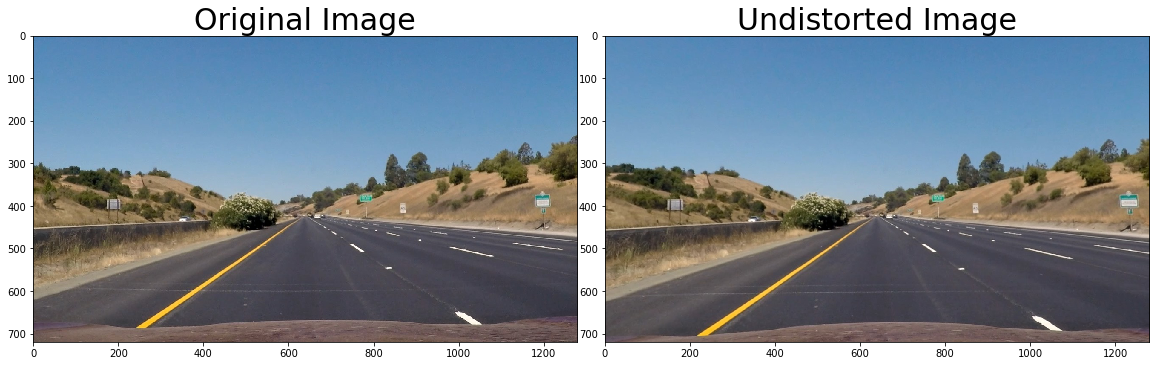

In [2]:
#read image
r_img = cv2.imread(r'C:\Users\resta\Desktop\SelfDrivingCarNanodegree\04AdvancedLineFinding\CarND-Advanced-Lane-Lines\test_images\straight_lines1.jpg')
b,g,r = cv2.split(r_img)       # get b,g,r
rgb_img = cv2.merge([r,g,b])     # switch it to rgb

def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

und_img = undistort(rgb_img)

# Visualize undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(rgb_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(und_img)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

## 3. Color/Gradient thresholding

In [3]:


gray = cv2.cvtColor(und_img, cv2.COLOR_BGR2GRAY)
#Calculate the derivative in the x direction
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)

#Calculate the derivative in the y direction
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

#Calculate the absolute value of the xx derivative:
abs_sobelx = np.absolute(sobelx)

#Convert the absolute value image to 8-bit:
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

thresh_min = 20
thresh_max = 180
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

### Gradient Sobelx and Sobely

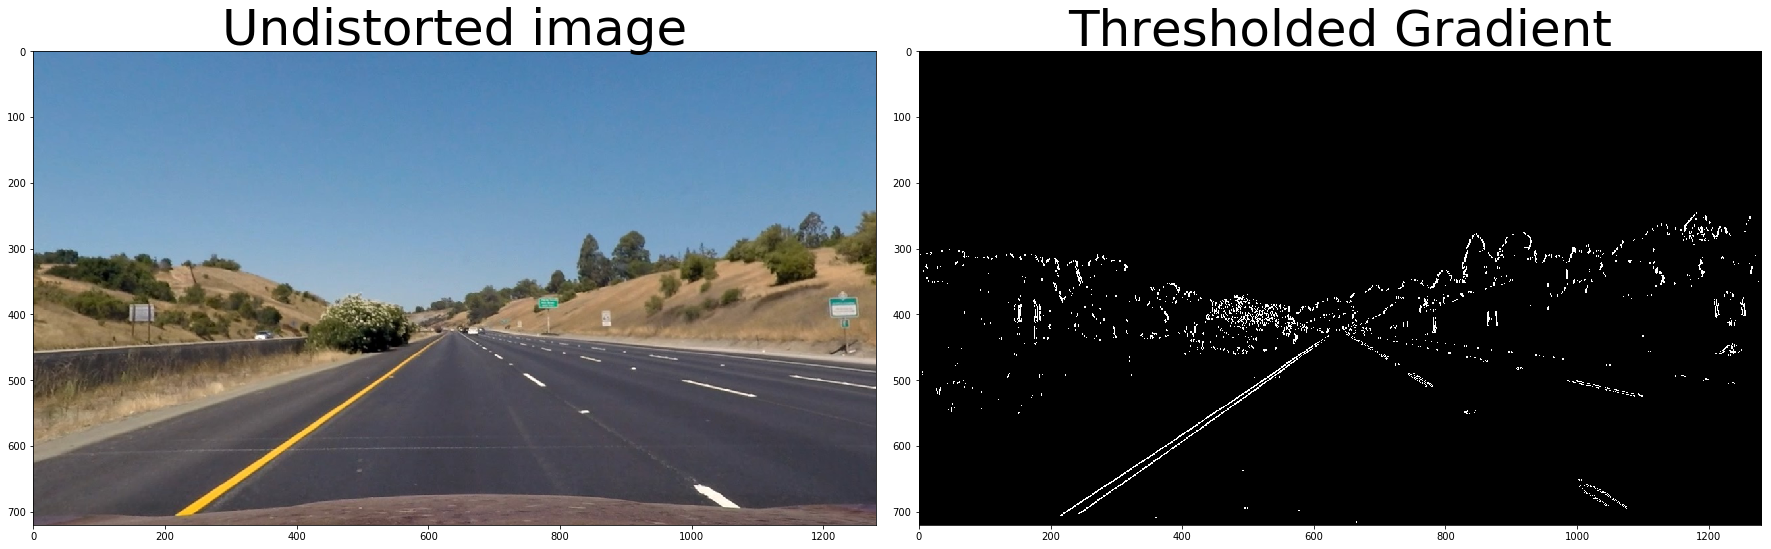

In [4]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(und_img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(und_img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Run the function
grad_binary = abs_sobel_thresh(und_img, orient='x', thresh_min=40, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(und_img)
ax1.set_title('Undistorted image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [5]:
gradx = abs_sobel_thresh(und_img, orient='x', thresh_min=40, thresh_max=100)
grady = abs_sobel_thresh(und_img, orient='y', thresh_min=40, thresh_max=100)

### Gradient magnitude

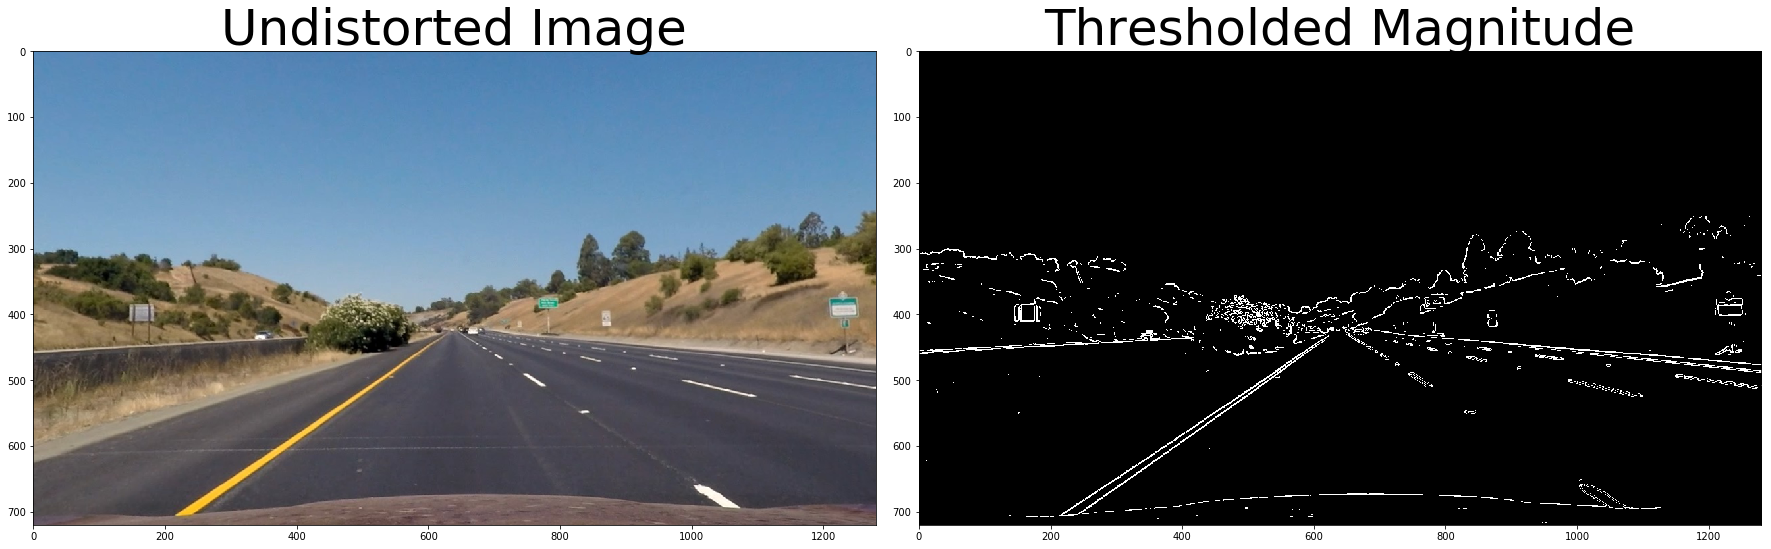

In [6]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Run the function
mag_binary = mag_thresh(und_img, sobel_kernel=3, mag_thresh=(60, 150))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(und_img)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### Gradient direction

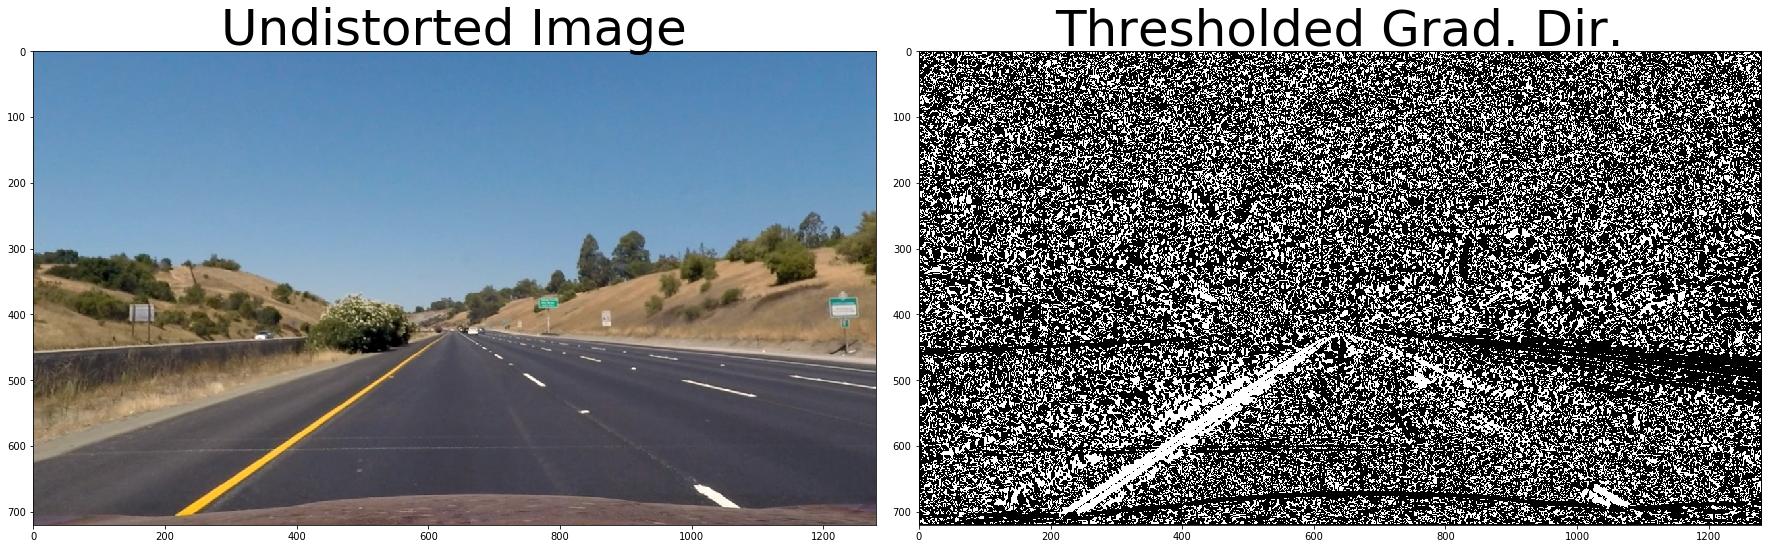

In [7]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Run the function
dir_binary = dir_threshold(und_img, sobel_kernel=15, thresh=(0.75, 1.25))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(und_img)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### Combining Thresholds

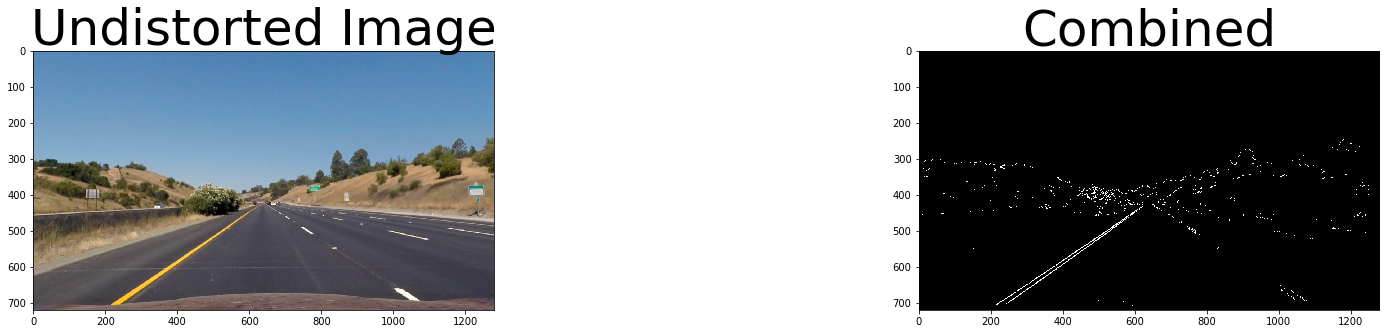

In [8]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(und_img)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=1.2, bottom=0.8)
plt.show()

### Color thresholding

#### Threshold S

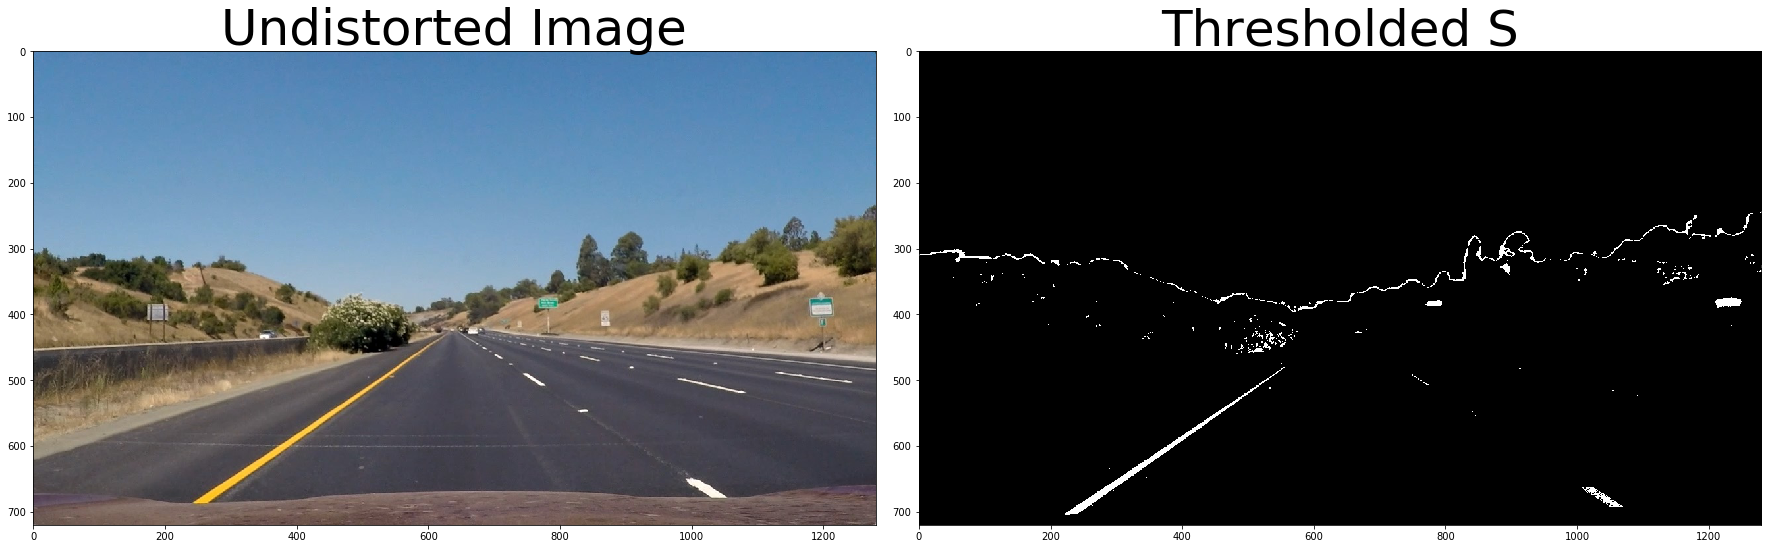

In [60]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    binary_output = np.zeros_like(s_channel)
    binary_output[((s_channel > thresh[0]) & (s_channel <= thresh[1])) | ((h_channel > 20) & (h_channel <= 40))] = 1
    return binary_output

s_binary = hls_select(und_img, thresh=(200, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(rgb_img)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(s_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

#### Threshold R

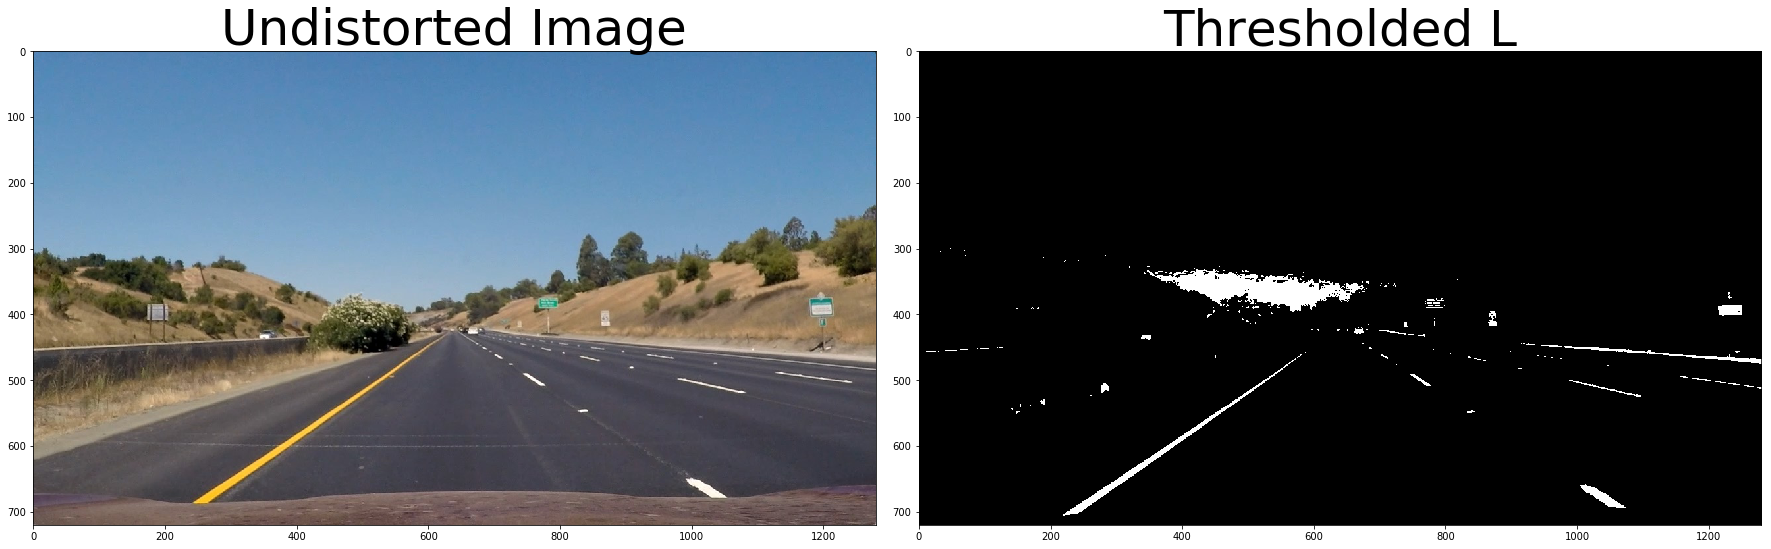

In [61]:
def l_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = img[:,:,1]
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output

l_binary = l_select(und_img, thresh=(180, 255) )

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(rgb_img)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(l_binary, cmap='gray')
ax2.set_title('Thresholded L', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### Combining S channel and L channel

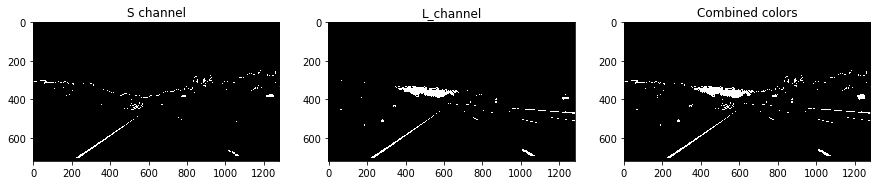

In [62]:
combined_colors = np.zeros_like(combined)
combined_colors[(s_binary == 1) | (r_binary == 1)] = 1

# Plotting s_channel image, r_channel image and combined thresholds image
f, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=False, sharey=False, figsize=(15,7.5))
ax1.set_title('S channel')
ax1.imshow(s_binary, cmap='gray')
ax2.set_title('L_channel')
ax2.imshow(l_binary, cmap='gray')
ax3.set_title('Combined colors')
ax3.imshow(combined_colors, cmap='gray')
plt.show()

### Combining color thresholds and gradient thresholds

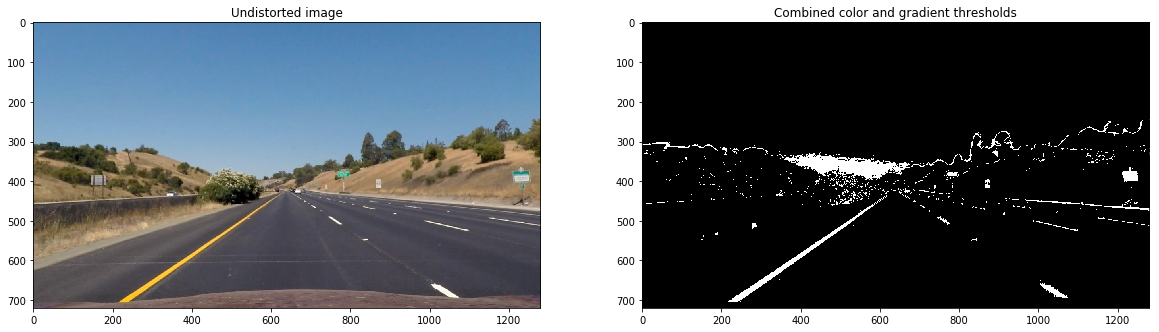

In [63]:
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

combined_binary = np.zeros_like(combined)
combined_binary[(combined_colors == 1) | (combined == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted image')
ax1.imshow(und_img)

ax2.set_title('Combined color and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')
plt.show()


## 4. Perspective Transform

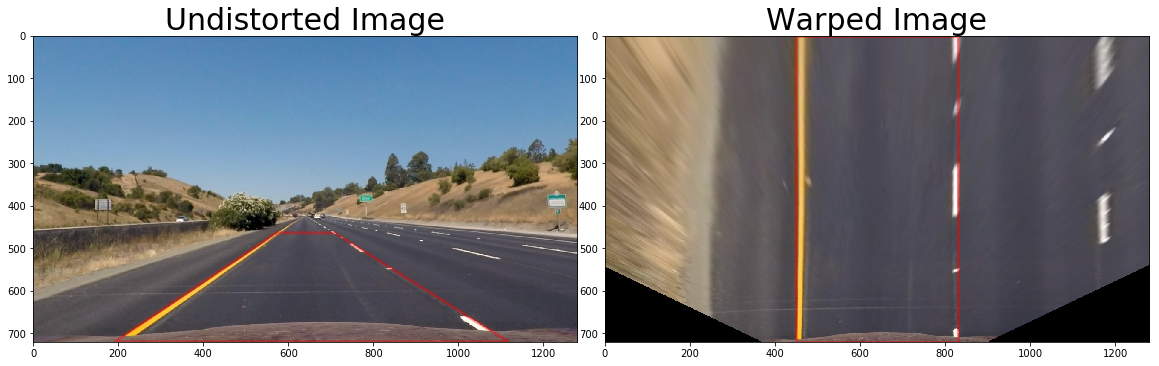

In [13]:
def warp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp the image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

h,w = und_img.shape[:2]

# define source and destination points for transform
src = np.float32([(572,464),
                  (709,464), 
                  (192,720), 
                  (1118,720)])
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

war_img, M, Minv = warp(und_img, src, dst)

# Visualize unwarped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(und_img)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(war_img)
xuw = [dst[0][0],dst[2][0],dst[3][0],dst[1][0],dst[0][0]]
yuw = [dst[0][1],dst[2][1],dst[3][1],dst[1][1],dst[0][1]]
ax2.plot(xuw, yuw, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax2.set_ylim([h,0])
ax2.set_xlim([0,w])
ax2.set_title('Warped Image', fontsize=30)

plt.show()

### Warping binary image

In [14]:
binary_warped, M, Minv = warp(combined_binary, src, dst)

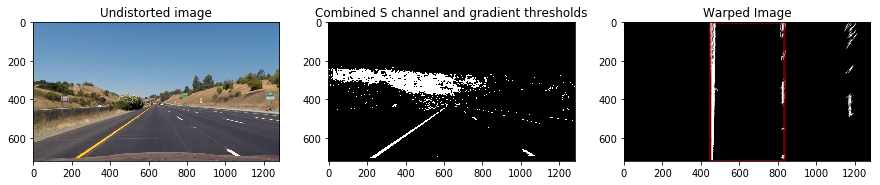

In [15]:
# Plotting original image, combined thresholds image and unwarped image
f, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=False, sharey=False, figsize=(15,7.5))
ax1.set_title('Undistorted image')
ax1.imshow(und_img)
ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')
ax3.imshow(binary_warped, cmap='gray')
xuw = [dst[0][0],dst[2][0],dst[3][0],dst[1][0],dst[0][0]]
yuw = [dst[0][1],dst[2][1],dst[3][1],dst[1][1],dst[0][1]]
ax3.plot(xuw, yuw, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax3.set_ylim([h,0])
ax3.set_xlim([0,w])
ax3.set_title('Warped Image')
plt.show()

## 5. Detect lane lines

[ 0.  0.  0. ...,  0.  0.  0.]
353.9375
1280
0.0


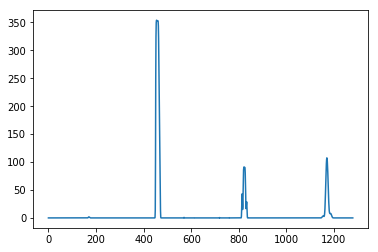

In [16]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
print(histogram)
print(max(histogram))
print(len(histogram))
print(histogram[445])
plt.plot(histogram)
plt.show()
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[250:midpoint]) + 250
rightx_base = np.argmax(histogram[midpoint:990]) + midpoint

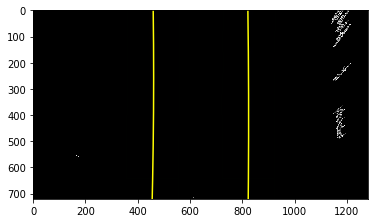

In [17]:
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2)
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [18]:
print(len(right_lane_inds))

6526


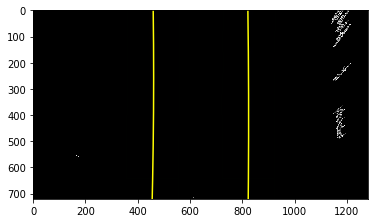

In [19]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

### When you know where the lines are

In [20]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

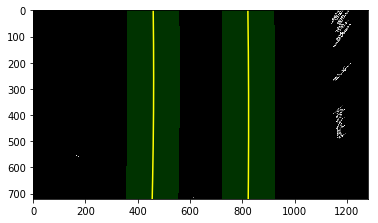

In [21]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

## 6. Determine the lane curvature

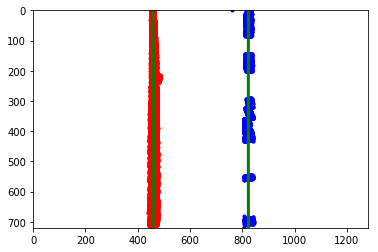

In [22]:
# Generate some fake data to represent lane-line pixels
#ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
#quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
#leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              #for y in ploty])
#rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                #for y in ploty])

rev_leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rev_rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

# Fit a second order polynomial to pixel positions in each fake lane line
lc_left_fit = np.polyfit(lefty, rev_leftx, 2)
lc_left_fitx = lc_left_fit[0]*lefty**2 + lc_left_fit[1]*lefty + lc_left_fit[2]
lc_right_fit = np.polyfit(righty, rev_rightx, 2)
lc_right_fitx = lc_right_fit[0]*righty**2 + lc_right_fit[1]*righty + lc_right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(rev_leftx, lefty, 'o', color='red', markersize=mark_size)
plt.plot(rev_rightx, righty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(lc_left_fitx, lefty, color='green', linewidth=3)
plt.plot(lc_right_fitx, righty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
plt.show()

### Define y-value where we want radius of curvature

In [23]:
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*lc_left_fit[0]*y_eval + lc_left_fit[1])**2)**1.5) / np.absolute(2*lc_left_fit[0])
right_curverad = ((1 + (2*lc_right_fit[0]*y_eval + lc_right_fit[1])**2)**1.5) / np.absolute(2*lc_right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

20114.7003575 128724.981848


### Define conversions in x and y from pixels space to meters

In [24]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

6396.69140423 m 10045.2963633 m


## 7. Inverse transform

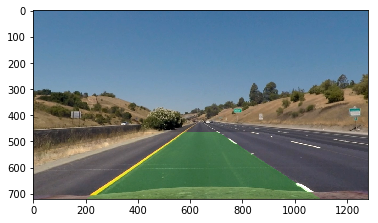

In [25]:
y_points = np.linspace(0, ((out_img.shape[0])-1), (out_img.shape[0]))

#print(y_points.shape)
#print(lefty.shape)

left_line_win = np.array([np.transpose(np.vstack([left_fitx, ploty]))])

right_line_win = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])

line_points = np.hstack((left_line_win, right_line_win))

#line_points = np.int32(np.vstack((left_line_win, right_line_win)))

fill_war_img = cv2.fillPoly(war_img, np.int_([line_points]), (0,255, 0))

unwarped = cv2.warpPerspective(war_img, Minv, (1280,720) , flags=cv2.INTER_LINEAR)

completed = cv2.addWeighted(und_img, 0.9, unwarped, 0.2, 0)

plt.imshow(completed)
plt.show()

## 8. Misure offset

In [26]:
#find center vehicle in pixels
center_vehicle = (result.shape[1])/2

#Find current vehicle position
actual_center = (np.mean(left_fitx)+(np.mean(right_fitx)))/2
offset = actual_center - center_vehicle
offset_meter = offset/(np.mean(right_fitx)-(np.mean(left_fitx)))

#Change from RGB to BGR
b,g,r = cv2.split(r_img)       # get b,g,r
rgb_img = cv2.merge([r,g,b])     # switch it to rgb

red, green, blue = cv2.split(completed)
bgr_complete = cv2.merge([blue,green,red])

# Put offset on the image

font                   = cv2.FONT_HERSHEY_SIMPLEX
position_offset        = (10,70)
position_curverad      = (10,40)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2

curv_mean = (left_curverad + right_curverad)/2.

cv2.putText(bgr_complete,"Offset: {0:.3f} m".format(offset_meter), position_offset, font, fontScale, fontColor, lineType)
cv2.putText(bgr_complete, "Radius of Curvature: {0:.0f} m".format(curv_mean), position_curverad, font, fontScale, fontColor, lineType )

cv2.imshow("img",bgr_complete)
cv2.waitKey(0)

-1

## 9. Video pipeline

### Class Line

In [27]:
# Define a class to receive the characteristics of each right line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #average curvature of the last n iterations
        self.rad_curv_mean = []
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

### Discover line function

In [28]:
def discover_line(binary_warped_p,margin):
    
    if l_line.detected!=True or r_line.detected!=True or wrong_data>4 or noi==1:
        #print("Complete calculation")
        nonzero = binary_warped_p.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        histogram = np.sum(binary_warped_p[binary_warped_p.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped_p, binary_warped_p, binary_warped_p))*255
        leftx_base = np.argmax(histogram[350:midpoint]) + 350
        rightx_base = np.argmax(histogram[midpoint:930]) + midpoint
        leftx_current = leftx_base
        rightx_current = rightx_base
        left_lane_inds = []
        right_lane_inds = []
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped_p.shape[0] - (window+1)*window_height
            win_y_high = binary_warped_p.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        ploty = np.linspace(0, binary_warped_p.shape[0]-1, binary_warped_p.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    else:
        #print("Fast calculation")
        nonzero = binary_warped_p.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (l_line.best_fit[0]*(nonzeroy**2) + l_line.best_fit[1]*nonzeroy + 
        l_line.best_fit[2] - margin)) & (nonzerox < (l_line.best_fit[0]*(nonzeroy**2) + 
        l_line.best_fit[1]*nonzeroy + l_line.best_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (r_line.best_fit[0]*(nonzeroy**2) + r_line.best_fit[1]*nonzeroy + 
        r_line.best_fit[2] - margin)) & (nonzerox < (r_line.best_fit[0]*(nonzeroy**2) + 
        r_line.best_fit[1]*nonzeroy + r_line.best_fit[2] + margin)))  
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped_p.shape[0]-1, binary_warped_p.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    #curvature
    rev_leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rev_rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    lc_left_fit = np.polyfit(lefty, rev_leftx, 2)
    lc_left_fitx = lc_left_fit[0]*lefty**2 + lc_left_fit[1]*lefty + lc_left_fit[2]
    lc_right_fit = np.polyfit(righty, rev_rightx, 2)
    lc_right_fitx = lc_right_fit[0]*righty**2 + lc_right_fit[1]*righty + lc_right_fit[2]
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*lc_left_fit[0]*y_eval + lc_left_fit[1])**2)**1.5) / np.absolute(2*lc_left_fit[0])
    right_curverad = ((1 + (2*lc_right_fit[0]*y_eval + lc_right_fit[1])**2)**1.5) / np.absolute(2*lc_right_fit[0])
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    print(left_curverad,"LEFT")
    print(right_curverad,"RIGHT")
    #inverse transform
    #if there are less than 2 numbers of iterations use left_fitx and right_fitx
    if noi<2:
        left_line_ = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_line_ = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    #if there are at least 2 numbers of iterations use l_line.bestx and r_line.bestx
    if noi>=2:
        left_line_ = np.array([np.transpose(np.vstack([l_line.bestx, ploty]))])
        right_line_ = np.array([np.flipud(np.transpose(np.vstack([r_line.bestx, ploty])))])
    line_points = np.hstack((left_line_, right_line_))
    fill_war_img = cv2.fillPoly(warped_img, np.int_([line_points]), (0,255, 0))
    unwarped = cv2.warpPerspective(warped_img, Minv, (1280,720) , flags=cv2.INTER_LINEAR)
    complete = cv2.addWeighted(undistorted, 0.9, unwarped, 0.1, 0)
    #find center vehicle in pixels
    center_vehicle = (complete.shape[1])/2
    #Find current vehicle position
    #if there are less than 2 number of iterations use:
    if noi<2:
        actual_center = (np.mean(left_fitx)+(np.mean(right_fitx)))/2
        offset = actual_center - center_vehicle
        offset_meter = offset/(np.mean(right_fitx)-(np.mean(left_fitx)))
    #if there are at least 2 number of iterations
    else:
        actual_center = (np.mean(l_line.bestx)+(np.mean(r_line.bestx)))/2
        offset = actual_center - center_vehicle
        offset_meter = offset/(np.mean(r_line.bestx)-(np.mean(l_line.bestx)))
    curv_mean = (left_curverad + right_curverad)/2
    
    return complete,left_fit,right_fit,left_curverad,right_curverad,offset_meter,curv_mean,left_fitx,right_fitx

#### Show different video on the screen

In [29]:
def screen(complete,warped_img,binary_warped_p):  
    widescreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
    widescreen[0:720, 0:1280] = complete[0]
    widescreen[0:480, 1280:1920] = cv2.resize(warped_img, (640,480), interpolation=cv2.INTER_AREA)
    three_bw=np.stack((binary_warped_p,)*3,axis=2)
    three_bw[:,:,0] = binary_warped_p
    three_bw[:,:,1] = binary_warped_p
    three_bw[:,:,2] = binary_warped_p
    new_three_bw=three_bw*255.
    widescreen[480:960, 1280:1920] = cv2.resize(new_three_bw, (640,480), interpolation=cv2.INTER_AREA)
    return widescreen

### Video pipeline

In [59]:
from moviepy.editor import VideoFileClip
l_line = Line()
r_line = Line()
#number of iterations
noi=0
wrong_data=0
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
search_margin = 40
# Set minimum number of pixels found to recenter window
minpix = 50
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
font                   = cv2.FONT_HERSHEY_SIMPLEX
position_offset        = (10,70)
position_curverad      = (10,40)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2
#read video
cap = cv2.VideoCapture('project_video.mp4')
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('project_output.avi',fourcc, 20.0, (1280,720))

while(cap.isOpened()):
    ret, frame = cap.read()
    
    if ret==True:
        #undistort image
        undistorted = undistort(frame)
        
        #gradient thresholds
        gradientx = abs_sobel_thresh(undistorted, orient='x', thresh_min=40, thresh_max=100)
        gradienty = abs_sobel_thresh(undistorted, orient='y', thresh_min=40, thresh_max=100)
        magnitude_binary = mag_thresh(undistorted, sobel_kernel=3, mag_thresh=(60, 150))
        direction_binary = dir_threshold(undistorted, sobel_kernel=3, thresh=(0.75, 1.25))
        combined_gradient = np.zeros_like(dir_binary)
        combined_gradient[((gradientx == 1) & (gradienty == 1)) | ((magnitude_binary == 1) & (direction_binary == 1))] = 1
        
        #color thresholds
        schannel_binary = hls_select(undistorted, thresh=(220, 255))
        rchannel_binary = l_select(undistorted, thresh=(220, 255) )
        combined_colors_gc = np.zeros_like(combined)
        combined_colors_gc[(schannel_binary == 1) | (rchannel_binary == 1)] = 1
        
        #merging thresholds
        combined_binary_gc = np.zeros_like(combined)
        combined_binary_gc[(combined_colors_gc == 1) | (combined_gradient == 1)] = 1
    
        #perspective transform
        warped_img, M, Minv = warp(undistorted, src, dst)
        binary_warped_p, M, Minv = warp(combined_binary_gc, src, dst)
        complete=discover_line(binary_warped_p,search_margin)
        
        #line curvature
        l_line.radius_of_curvature=complete[3]
        r_line.radius_of_curvature=complete[4]
        #append data
        l_line.recent_xfitted.append(complete[7])
        r_line.recent_xfitted.append(complete[8])
        l_line.rad_curv_mean.append(complete[3])
        r_line.rad_curv_mean.append(complete[4])
        
        #save left_fit and right_fit
        l_line.best_fit=complete[1]
        r_line.best_fit=complete[2]
        
        #SANITY CHECK
        #iterate over the last 15 valid misuration
        if noi<20:
            noi=noi+1
        l_line.bestx=np.mean((l_line.recent_xfitted[len(l_line.recent_xfitted)-noi:(len(l_line.recent_xfitted))-1]),
                             axis=0)
        r_line.bestx=np.mean((r_line.recent_xfitted[len(r_line.recent_xfitted)-noi:(len(r_line.recent_xfitted))-1]),
                            axis=0)
        
        #check to see if lines were detected
        if complete[1]!=None:
            l_line.detected=True
        else:
            l_line.detected=False
        if complete[2]!=None:
            r_line.detected=True
        else:
            r_line.detected=False
        
        if (len(l_line.recent_xfitted))>0 and (len(r_line.recent_xfitted))>0:
            #check to see if curvature were roughly similar
            if abs(log(l_line.radius_of_curvature,2)-log(r_line.radius_of_curvature,2))>0.75:
                l_line.detected=False
                print("error. radius of curvature is too different")
            if (abs(np.mean((l_line.bestx))-(np.mean(complete[7]))))>100:
                #error. line moved too 
                l_line.detected=False
                print("error mean x is over 100 pixel actual x left")
            if (abs(np.mean((r_line.bestx))-(np.mean(complete[8]))))>100:
                r_line.detected=False
                print("error mean x is over 100 pixel actual x right")
            #check if distance between lines increase or decrease too much
            if (abs(np.mean((complete[7]))+np.mean((complete[8]))
                    -(np.mean((l_line.recent_xfitted[((len(l_line.recent_xfitted))-noi):])))
                   -(np.mean((r_line.recent_xfitted[((len(r_line.recent_xfitted))-noi):])))))>50:
                l_line.detected=False
                print("distance between lines increased too much")
            #eliminate data that not fit
            if l_line.detected==False or r_line.detected==False:
                l_line.recent_xfitted.pop()
                r_line.recent_xfitted.pop()
                l_line.detected=False
                wrong_data=wrong_data+1
                if noi<=20:
                    noi=noi-1
                if wrong_data>15:
                    noi=0
                    wrong_data=0
            else:
                if wrong_data>0:
                    wrong_data=wrong_data-1
        
        #write offset and radius of curvature on the image
        if complete[5]>0:
            cv2.putText(complete[0],"Offset: {0:.3f}m right of center ".format(complete[5]), position_offset, font, fontScale, fontColor, lineType)
        if complete[5]<=0:
            cv2.putText(complete[0],"Offset: {0:.3f}m left of center".format(abs(complete[5])), position_offset, font, fontScale, fontColor, lineType)
        cv2.putText(complete[0], "Radius of Curvature: {0:.0f}m".format(complete[6]), position_curverad, font, fontScale, fontColor, lineType )
    
        #stream video
        video_output=screen(complete,warped_img,binary_warped_p)
        
        cv2.imshow('frame', video_output)
        
        #write image
        out.write(complete[0])
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
            
    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()

2142.05534591 LEFT
1877.71002993 RIGHT
3183.37697575 LEFT
1285.22949172 RIGHT
error. radius of curvature is too different
2920.78684125 LEFT
976.264869094 RIGHT
error. radius of curvature is too different
3066.81194953 LEFT
1032.66040024 RIGHT
error. radius of curvature is too different
4130.44509704 LEFT
1133.05708728 RIGHT
error. radius of curvature is too different
6164.85312985 LEFT
3238.86539179 RIGHT
error. radius of curvature is too different
8029.64543989 LEFT
2426.33036144 RIGHT
error. radius of curvature is too different
8320.82593346 LEFT
2175.27392967 RIGHT
error. radius of curvature is too different
11190.4138389 LEFT
2159.34370403 RIGHT
error. radius of curvature is too different
49475.7095006 LEFT
29672.2641255 RIGHT
5353.51264785 LEFT
10140.4714136 RIGHT
error. radius of curvature is too different
7854.50861604 LEFT
7856.96580328 RIGHT
35619.4265747 LEFT
3411.25998091 RIGHT
error. radius of curvature is too different
5316.05913714 LEFT
5164.02673438 RIGHT
8378.5341385 L

TypeError: expected non-empty vector for x